## Packages

In [1]:
import os, sys
os.environ["DISPLAY"] = ":1.0"
os.environ["PYVISTA_OFF_SCREEN"]="true"
os.environ["PYVISTA_USE_PANEL"]="true"
os.environ["PYVISTA_AUTO_CLOSE"]="false"
os.system("Xvfb :1 -screen 0 1024x768x24 > /dev/null 2>&1 &")

0

In [2]:
from omegaconf import OmegaConf
import pyvista as pv
import torch
import numpy as np

In [3]:
DIR = "C:\\Users\\olvcp\\3Dpointclouds"

## Configuration

In [4]:
#@title Configure the dataset {run: "auto"}
CATEGORY = "Airplane" #@param ["Airplane", "Bag", "All", "Motorbike"] {allow-input: true}
USE_NORMALS = True #@param {type:"boolean"}|

In [5]:
shapenet_yaml = """
class: shapenet.ShapeNetDataset
task: segmentation
dataroot: %s
normal: %r                                    # Use normal vectors as features
first_subsampling: 0.02                       # Grid size of the input data
pre_transforms:                               # Offline transforms, done only once
    - transform: NormalizeScale           
    - transform: GridSampling3D
      params:
        size: ${first_subsampling}
train_transforms:                             # Data augmentation pipeline
    - transform: RandomNoise
      params:
        sigma: 0.01
        clip: 0.05
    - transform: RandomScaleAnisotropic
      params:
        scales: [0.9,1.1]
    - transform: AddOnes
    - transform: AddFeatsByKeys
      params:
        list_add_to_x: [True]
        feat_names: ["ones"]
        delete_feats: [True]
test_transforms:
    - transform: AddOnes
    - transform: AddFeatsByKeys
      params:
        list_add_to_x: [True]
        feat_names: ["ones"]
        delete_feats: [True]
""" % (os.path.join(DIR,"data"), USE_NORMALS)

from omegaconf import OmegaConf
params = OmegaConf.create(shapenet_yaml)
if CATEGORY != "All":
    params.category = CATEGORY

## Dataset

In [6]:
from torch_points3d.datasets.segmentation import ShapeNetDataset
dataset = ShapeNetDataset(params)
dataset

Dataset: ShapeNetDataset 
train_pre_batch_collate_transform = None
val_pre_batch_collate_transform = None
test_pre_batch_collate_transform = None
pre_transform = Compose([
    NormalizeScale(),
    GridSampling3D(grid_size=0.02, quantize_coords=False, mode=mean),
])
test_transform = Compose([
    AddOnes(),
    AddFeatsByKeys(ones=True),
])
train_transform = Compose([
    RandomNoise(sigma=0.01, clip=0.05),
    RandomScaleAnisotropic([0.9, 1.1]),
    AddOnes(),
    AddFeatsByKeys(ones=True),
])
val_transform = None
inference_transform = Compose([
    NormalizeScale(),
    GridSampling3D(grid_size=0.02, quantize_coords=False, mode=mean),
    AddOnes(),
    AddFeatsByKeys(ones=True),
])
Size of train_dataset = 1958
Size of test_dataset = 341
Size of val_dataset = 391
Batch size = None

C:\Users\olvcp\anaconda3\envs\pointclouds\lib\site-packages\pyvista\jupyter\notebook.py:60: UserWarning: Failed to use notebook backend: 

DLL load failed while importing vtkIONetCDF: The specified procedure could not be found.

Falling back to a static output.
  warnings.warn(


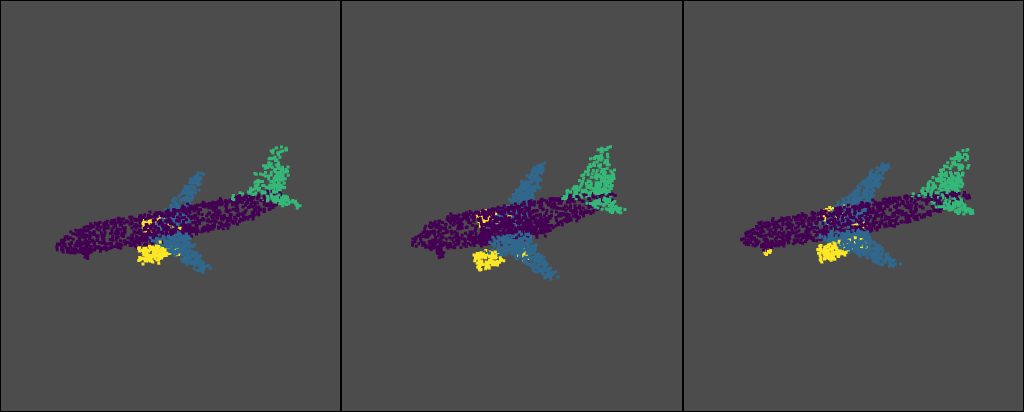

In [7]:
#@title Plot samples with part annotations { run: "auto" }
objectid_1 = 9 #@param {type:"slider", min:0, max:100, step:1}
objectid_2 = 82 #@param {type:"slider", min:0, max:100, step:1}
objectid_3 = 95 #@param {type:"slider", min:0, max:100, step:1}

samples = [objectid_1, objectid_2, objectid_3]
p = pv.Plotter(notebook=True,shape=(1, len(samples)),window_size=[1024,412])
for i in range(len(samples)):
    p.subplot(0, i)
    sample = dataset.train_dataset[samples[i]]
    point_cloud = pv.PolyData(sample.pos.numpy())
    point_cloud['y'] = sample.y.numpy()
    p.add_points(point_cloud,  show_scalar_bar=False, point_size=3)
    p.camera_position = [-1,5, -10]
p.show()

## Segmentation

In [8]:
from torch_points3d.core.common_modules import MLP, UnaryConv

class MultiHeadClassifier(torch.nn.Module):
    """ Allows segregated segmentation in case the category of an object is known. 
    This is the case in ShapeNet for example.

    Parameters
    ----------
    in_features -
        size of the input channel
    cat_to_seg
        category to segment maps for example:
        {
            'Airplane': [0,1,2],
            'Table': [3,4]
        }

    """

    def __init__(self, in_features, cat_to_seg, dropout_proba=0.5, bn_momentum=0.1):
        super().__init__()
        self._cat_to_seg = {}
        self._num_categories = len(cat_to_seg)
        self._max_seg_count = 0
        self._max_seg = 0
        self._shifts = torch.zeros((self._num_categories,), dtype=torch.long)
        for i, seg in enumerate(cat_to_seg.values()):
            self._max_seg_count = max(self._max_seg_count, len(seg))
            self._max_seg = max(self._max_seg, max(seg))
            self._shifts[i] = min(seg)
            self._cat_to_seg[i] = seg

        self.channel_rasing = MLP(
            [in_features, self._num_categories * in_features], bn_momentum=bn_momentum, bias=False
        )
        if dropout_proba:
            self.channel_rasing.add_module("Dropout", torch.nn.Dropout(p=dropout_proba))

        self.classifier = UnaryConv((self._num_categories, in_features, self._max_seg_count))
        self._bias = torch.nn.Parameter(torch.zeros(self._max_seg_count,))

    def forward(self, features, category_labels, **kwargs):
        assert features.dim() == 2
        self._shifts = self._shifts.to(features.device)
        in_dim = features.shape[-1]
        features = self.channel_rasing(features)
        features = features.reshape((-1, self._num_categories, in_dim))
        features = features.transpose(0, 1)  # [num_categories, num_points, in_dim]
        features = self.classifier(features) + self._bias  # [num_categories, num_points, max_seg]
        ind = category_labels.unsqueeze(-1).repeat(1, 1, features.shape[-1]).long()

        logits = features.gather(0, ind).squeeze(0)
        softmax = torch.nn.functional.log_softmax(logits, dim=-1)

        output = torch.zeros(logits.shape[0], self._max_seg + 1).to(features.device)
        cats_in_batch = torch.unique(category_labels)
        for cat in cats_in_batch:
            cat_mask = category_labels == cat
            seg_indices = self._cat_to_seg[cat.item()]
            probs = softmax[cat_mask, : len(seg_indices)]
            output[cat_mask, seg_indices[0] : seg_indices[-1] + 1] = probs
        
        return output

In [9]:
from torch_points3d.applications.kpconv import KPConv


class PartSegKPConv(torch.nn.Module):
    def __init__(self, cat_to_seg):
        super().__init__()
        self.unet = KPConv(
            architecture="unet", 
            input_nc=USE_NORMALS * 3, 
            num_layers=4, 
            in_grid_size=0.02
            )
        self.classifier = MultiHeadClassifier(self.unet.output_nc, cat_to_seg)
    
    @property
    def conv_type(self):
        """ This is needed by the dataset to infer which batch collate should be used"""
        return self.unet.conv_type
    
    def get_batch(self):
        return self.batch
    
    def get_output(self):
        """ This is needed by the tracker to get access to the ouputs of the network"""
        return self.output
    
    def get_labels(self):
        """ Needed by the tracker in order to access ground truth labels"""
        return self.labels
    
    def get_current_losses(self):
        """ Entry point for the tracker to grab the loss """
        return {"loss_seg": float(self.loss_seg)}

    def forward(self, data):
        self.labels = data.y
        self.batch = data.batch
        
        # Forward through unet and classifier
        data_features = self.unet(data)
        self.output = self.classifier(data_features.x, data.category)

         # Set loss for the backward pass
        self.loss_seg = torch.nn.functional.nll_loss(self.output, self.labels)
        return self.output

    def get_spatial_ops(self):
        return self.unet.get_spatial_ops()
        
    def backward(self):
         self.loss_seg.backward() 

    

In [10]:
model = PartSegKPConv(dataset.class_to_segments)

## Dataloader

In [11]:
NUM_WORKERS = 4
BATCH_SIZE = 16
dataset.create_dataloaders(
    model,
    batch_size=BATCH_SIZE, 
    num_workers=NUM_WORKERS, 
    shuffle=True, 
    precompute_multi_scale=True 
    )

In [12]:
sample = next(iter(dataset.train_dataloader))
sample.keys

['x',
 'y',
 'pos',
 'multiscale',
 'upsample',
 'batch',
 'category',
 'grid_size',
 'id_scan',
 'origin_id',
 'ptr']

In [13]:
sample.multiscale

[Batch(batch=[34363], idx_neighboors=[34363, 25], pos=[34363, 3]),
 Batch(batch=[34363], idx_neighboors=[34363, 25], pos=[34363, 3]),
 Batch(batch=[19203], grid_size=[16], idx_neighboors=[19203, 25], pos=[19203, 3]),
 Batch(batch=[19203], idx_neighboors=[19203, 25], pos=[19203, 3]),
 Batch(batch=[5608], grid_size=[16], idx_neighboors=[5608, 25], pos=[5608, 3]),
 Batch(batch=[5608], idx_neighboors=[5608, 25], pos=[5608, 3]),
 Batch(batch=[1303], grid_size=[16], idx_neighboors=[1303, 25], pos=[1303, 3]),
 Batch(batch=[1303], idx_neighboors=[1303, 25], pos=[1303, 3]),
 Batch(batch=[335], grid_size=[16], idx_neighboors=[335, 25], pos=[335, 3]),
 Batch(batch=[335], idx_neighboors=[335, 25], pos=[335, 3])]

## Downsampling

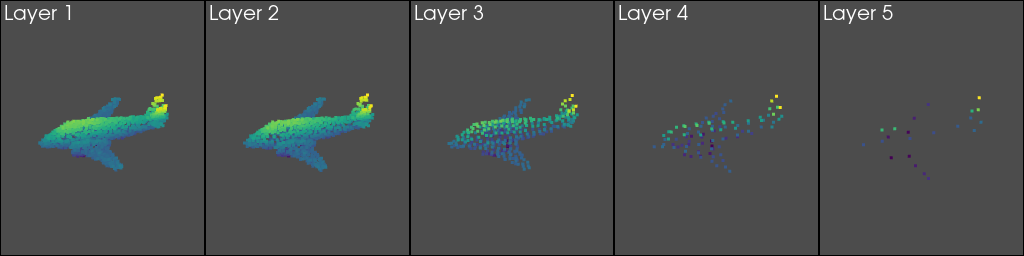

In [14]:
#@title Successive downsampling {run:"auto"}
sample_in_batch = 0 #@param {type:"slider", min:0, max:5, step:1}
ms_data = sample.multiscale 
num_downsize = int(len(ms_data) / 2)
p = pv.Plotter(notebook=True,shape=(1, num_downsize),window_size=[1024,256])
for i in range(0,num_downsize):
    p.subplot(0, i)
    pos = ms_data[2*i].pos[ms_data[2*i].batch == sample_in_batch].numpy()
    point_cloud = pv.PolyData(pos)
    point_cloud['y'] = pos[:,1]
    p.add_points(point_cloud,  show_scalar_bar=False, point_size=3)
    p.add_text("Layer {}".format(i+1),font_size=10)
    p.camera_position = [-1,5, -10]
p.show()

## Neighborhood

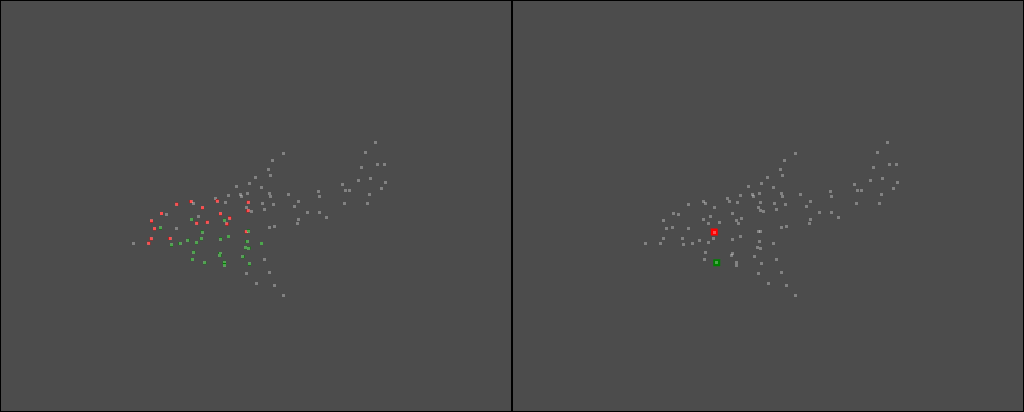

In [15]:
#@title Explore Neighborhood {run: "auto"}
selected_layer = 7 #@param {type:"slider", min:1, max:9, step:1}
sample_in_batch = 0 #@param {type:"slider", min:0, max:5, step:1}
point1_id = 46 #@param {type:"slider", min:0, max:600, step:1}
point2_id = 10 #@param {type:"slider", min:0, max:600, step:1}

p = pv.Plotter(notebook=True,shape=(1, 2),window_size=[1024,412])

# Selected layer
p.subplot(0, 1)
ms_data = sample.multiscale[selected_layer]
pos = ms_data.pos[ms_data.batch == sample_in_batch].numpy()
nei = ms_data.idx_neighboors[ms_data.batch == sample_in_batch]
point_cloud = pv.PolyData(pos)
p.add_points(point_cloud,  show_scalar_bar=False, point_size=3,opacity=0.3)
p.add_points(pos[point1_id,:],  show_scalar_bar=False, point_size=7.0,color='red')
p.add_points(pos[point2_id,:],  show_scalar_bar=False, point_size=7.0,color='green')
p.camera_position = [-1,5, -10]

# Previous layer
p.subplot(0, 0)
ms_data = sample.multiscale[selected_layer-1]
pos = ms_data.pos[ms_data.batch == sample_in_batch].numpy()
point_cloud = pv.PolyData(pos)
p.add_points(point_cloud,  show_scalar_bar=False,point_size=3, opacity=0.3)
nei_pos = ms_data.pos[nei[point1_id]].numpy()
nei_pos = nei_pos[nei[point1_id] >= 0]
p.add_points(nei_pos,  show_scalar_bar=False, point_size=3.0,color='red')
nei_pos = ms_data.pos[nei[point2_id]].numpy()
nei_pos = nei_pos[nei[point2_id] >= 0]
p.add_points(nei_pos,  show_scalar_bar=False, point_size=3.0,color='green')
p.camera_position = [-1,5, -10]

p.show()

## Training

In [16]:
from tqdm.auto import tqdm
import time

class Trainer:
    def __init__(self,model, dataset, num_epoch = 50, device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")):
        self.num_epoch = num_epoch
        self._model = model
        self._dataset=dataset
        self.device = device

    def fit(self):
        self.optimizer = torch.optim.Adam(self._model.parameters(), lr=0.001)
        self.tracker = self._dataset.get_tracker(False, True)

        for i in range(self.num_epoch):
            print("=========== EPOCH %i ===========" % i)
            time.sleep(0.5)
            self.train_epoch()
            self.tracker.publish(i)
            self.test_epoch()
            self.tracker.publish(i)

    def train_epoch(self):
        self._model.to(self.device)
        self._model.train()
        self.tracker.reset("train")
        train_loader = self._dataset.train_dataloader
        iter_data_time = time.time()
        with tqdm(train_loader) as tq_train_loader:
            for i, data in enumerate(tq_train_loader):
                t_data = time.time() - iter_data_time
                iter_start_time = time.time()
                self.optimizer.zero_grad()
                data.to(self.device)
                self._model.forward(data)
                self._model.backward()
                self.optimizer.step()
                if i % 10 == 0:
                    self.tracker.track(self._model)

                tq_train_loader.set_postfix(
                    **self.tracker.get_metrics(),
                    data_loading=float(t_data),
                    iteration=float(time.time() - iter_start_time),
                )
                iter_data_time = time.time()

    def test_epoch(self):
        self._model.to(self.device)
        self._model.eval()
        self.tracker.reset("test")
        test_loader = self._dataset.test_dataloaders[0]
        iter_data_time = time.time()
        with tqdm(test_loader) as tq_test_loader:
            for i, data in enumerate(tq_test_loader):
                t_data = time.time() - iter_data_time
                iter_start_time = time.time()
                data.to(self.device)
                self._model.forward(data)           
                self.tracker.track(self._model)

                tq_test_loader.set_postfix(
                    **self.tracker.get_metrics(),
                    data_loading=float(t_data),
                    iteration=float(time.time() - iter_start_time),
                )
                iter_data_time = time.time()

In [17]:
trainer = Trainer(model, dataset)

In [18]:
trainer.fit()

=========== EPOCH 0 ===========


  0%|          | 0/123 [00:00<?, ?it/s]

KeyboardInterrupt: 